# <center>Assignment 2 LSTM - Fixed Window Size Loop With Unadjusted-Seasonality Data

In [321]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [322]:
# Basic Time Series Setting
import statsmodels.api as smapi
import statsmodels.tsa.api as smt

In [323]:
# RNN Package Setting
import time
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras import optimizers

np.random.seed(1)

## Data Preparation

In [324]:
data=pd.read_csv('internet_retail_sales.csv',parse_dates=[0], index_col=0)
sales=data.values

### Standardisation

In [325]:
# Standardisation
scaler = StandardScaler()
sales_scaled=scaler.fit_transform(sales)

# Std & Mean Calculation
data_std=np.std(sales)
data_mean=np.mean(sales)

print(data_std)
print(data_mean)

326.51619183478374
599.4138686131387


### Fixed Data Window

In [326]:
# Creating Training and Test feature
time_window=12

Xall, yall=[],[]

for i in range(time_window, len(sales_scaled)):
    Xall.append(sales_scaled[i-time_window:i,0])
    yall.append(sales_scaled[i,0])

Xall=np.array(Xall)
yall=np.array(yall)

### Train Test Split

#### Real Test Split for Hold out

In [313]:
test_size=12
Xtrain, Xtest=Xall[0:-test_size], Xall[-test_size:]
ytrain, ytest=yall[0:-test_size], yall[-test_size:]

# Unscaled Data Preparation for Evaluation
y_train_raw=sales[0:-test_size]
y_test_raw=sales[-test_size:]

#### Pseudo Test Split for Validation

In [314]:
Xtrain_pse, Xtest_pse=Xtrain[0:-test_size], Xtrain[-test_size:]
ytrain_pse, ytest_pse=ytrain[0:-test_size], ytrain[-test_size:]

# Unscaled Data Preparation for Evaluation
y_train_pse_raw=y_train_raw[0:-test_size]
y_test_pse_raw=y_train_raw[-test_size:]

### Reshape Data Window into 3D

In [315]:
# Real Train Test Split
Xtrain, Xtest=Xtrain.reshape(Xtrain.shape[0], time_window, 1), Xtest.reshape(Xtest.shape[0], time_window, 1)
# Pseudo Train Test Split
Xtrain_pse, Xtest_pse=Xtrain_pse.reshape(Xtrain_pse.shape[0], time_window, 1), Xtest_pse.reshape(Xtest_pse.shape[0], time_window, 1)

print(Xtrain.shape)
print(Xtest.shape)

print(Xtrain_pse.shape)
print(Xtest_pse.shape)

(113, 12, 1)
(12, 12, 1)
(101, 12, 1)
(12, 12, 1)


## RNN-Fixed Window Size Model Fitting

In [328]:
# Model Fitting
epochs=1
repeats=2

neurons_min=1
neurons_max=2

window_min=12
window_max=13

step=1

# train_loss=np.zeros(shape=(window_max-window_min,int((neurons_max-neurons_min)/5)))
# cv_loss=np.zeros(shape=(window_max-window_min,int((neurons_max-neurons_min)/5)))
# test_loss=[np.zeros(shape=(window_max-window_min,int((neurons_max-neurons_min)/5)))]
train_loss=[]
train_loss_res=[]

cv_loss=[]
cv_loss_res=[]

test_loss=[]

for w in range(window_min,window_max):
       
    time_window=w

    Xall, yall=[],[]
    for i in range(time_window, len(sales_scaled)):
        Xall.append(sales_scaled[i-time_window:i,0])
        yall.append(sales_scaled[i,0])     
    Xall=np.array(Xall)
    yall=np.array(yall)
    
    # Real Train Test Split
    test_size=12
    Xtrain, Xtest=Xall[0:-test_size], Xall[-test_size:]
    ytrain, ytest=yall[0:-test_size], yall[-test_size:]
    # Unscaled Data Preparation for Evaluation
    y_train_raw=sales[0:-test_size]
    y_test_raw=sales[-test_size:]

    # Validation Train Test Split
    Xtrain_pse, Xtest_pse=Xtrain[0:-test_size], Xtrain[-test_size:]
    ytrain_pse, ytest_pse=ytrain[0:-test_size], ytrain[-test_size:]
    # Unscaled Data Preparation for Evaluation
    y_train_pse_raw=y_train_raw[0:-test_size]
    y_test_pse_raw=y_train_raw[-test_size:]

    # Real Train Test Split Reshape 
    Xtrain, Xtest=Xtrain.reshape(Xtrain.shape[0], time_window, 1), Xtest.reshape(Xtest.shape[0], time_window, 1)
    # Validation Train Test Split Reshape
    Xtrain_pse, Xtest_pse=Xtrain_pse.reshape(Xtrain_pse.shape[0], time_window, 1), Xtest_pse.reshape(Xtest_pse.shape[0], time_window, 1)


    for n in range(neurons_min,neurons_max,step):
    #         fig=plt.figure()  
        rmse_t=[]
        for j in range(repeats):

            model=Sequential()
            model.add(LSTM(n,input_shape = (time_window,1), batch_size=1,stateful=True))
            model.add(Dropout(0.2))
            model.add(Dense(1,activation='linear'))
            #     model.add(Dense(1))

            # compile model for use
            start=time.time()
            model.compile(loss="mse", optimizer="rmsprop")
            print("Compilation Time : ", time.time() - start)

            train_loss_t=[]
            cv_loss_t=[]   
            for i in range(epochs):
                history=model.fit(Xtrain_pse,ytrain_pse, epochs=1, batch_size=1, verbose=2,validation_split=0.1,shuffle=False)
                train_loss_t.append(history.history['loss'])
                cv_loss_t.append(history.history['val_loss'])
                model.reset_states()

            # Loss Calculation  
            # Test RMSE - For my own happiness
            test_predict_pse = model.predict(Xtest_pse,batch_size=1)
            test_predict_pse=scaler.inverse_transform(test_predict_pse)    
            rmse_t.append(math.sqrt(mean_squared_error(y_test_pse_raw,test_predict_pse)))
                
            # cross validation loss
            cv_loss.append(np.array(cv_loss_t))
            cv_loss_res.append(np.array(cv_loss_t)*data_std)
            # training loss
            train_loss.append(np.array(train_loss_t))            
            train_loss_res.append(np.array(train_loss_t)*data_std)
            
        # calculate mean and std of muti-rmse
        rmse_t.append(np.mean(rmse_t))
        rmse_t.append(np.std(rmse_t))
        test_loss.append(rmse_t)

# plt.plot(train_loss,color='blue')
# plt.plot(cv_loss,color='orange')
    
# plt.title('model train vs validation loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# # # plt.legend(['train', 'validation'], loc='upper right')
# plt.show()
# fig.savefig('epochs_tuning.png',dpi=1000)

Compilation Time :  0.025173187255859375
Train on 90 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5851 - val_loss: 0.9007
Compilation Time :  0.01096343994140625
Train on 90 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1689 - val_loss: 0.4980


In [329]:
test_loss

[[500.8493973603309,
  436.1133356738504,
  468.48136651709063,
  26.428386514868855]]

In [330]:
train_loss

[array([[0.58513226]]), array([[0.16889615]])]

In [331]:
cv_loss

[array([[0.9006817]]), array([[0.49802812]])]

In [332]:
cv_loss_res

[array([[294.08715881]]), array([[162.61424541]])]

In [333]:
train_loss_res

[array([[191.05515749]]), array([[55.14732674]])]

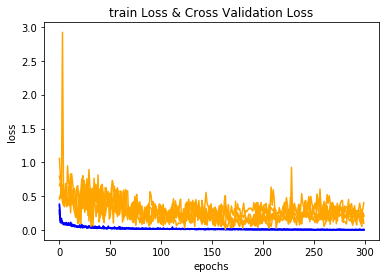

In [303]:
# Cross Validation Visualization
fig=plt.figure()
plt.plot(np.array(train_loss)[0,:],color='blue')
plt.plot(np.array(train_loss)[1,:],color='blue')
plt.plot(np.array(train_loss)[2,:],color='blue')
plt.plot(np.array(train_loss)[3,:],color='blue')
plt.plot(np.array(train_loss)[4,:],color='blue')

plt.plot(np.array(cv_loss)[0,:],color='orange')
plt.plot(np.array(cv_loss)[1,:],color='orange')
plt.plot(np.array(cv_loss)[2,:],color='orange')
plt.plot(np.array(cv_loss)[3,:],color='orange')
plt.plot(np.array(cv_loss)[4,:],color='orange')


# plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train Loss & Cross Validation Loss')
plt.show()
fig.savefig('loss_output.png',dpi=1000)

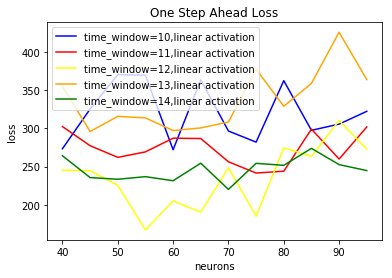

In [268]:
fig=plt.figure()
plt.plot(np.arange(40,100,5),test_loss.iloc[0,:],label='time_window=10,linear activation',color='blue')
plt.plot(np.arange(40,100,5),test_loss.iloc[1,:],label='time_window=11,linear activation',color='red')
plt.plot(np.arange(40,100,5),test_loss.iloc[2,:],label='time_window=12,linear activation',color='yellow')
plt.plot(np.arange(40,100,5),test_loss.iloc[3,:],label='time_window=13,linear activation',color='orange')
plt.plot(np.arange(40,100,5),test_loss.iloc[4,:],label='time_window=14,linear activation',color='green')
plt.legend()
plt.xlabel('neurons')
plt.ylabel('loss')
plt.title('One Step Ahead Loss')
plt.show()
fig.savefig('loss_output.png',dpi=1000)

In [269]:
test_loss.to_excel('Loss_T10-14_N40-100.xlsx')

In [200]:
# Predict
train_predict = model.predict(Xtrain,batch_size=1)
test_predict = model.predict(Xtest,batch_size=1)

# Inverse Prediction
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

## Training Score

In [201]:
# epochs_summary=[]
# neurons_summary=[]
# rmse_summary=[]
# mae_summary=[]

In [202]:
rmse=math.sqrt(mean_squared_error(y_test_raw,test_predict))
mae=mean_absolute_error(y_test_raw,test_predict)

In [203]:
epochs_summary.append(epochs)
neurons_summary.append(neurons)
rmse_summary.append(rmse)
mae_summary.append(mae)

print(epochs_summary)
print(neurons_summary)
print(rmse_summary)
print(mae_summary)

[300, 300, 300, 300, 300, 300, 300]
[5, 10, 50, 100, 150, 125, 113]
[318.7349936417306, 230.30975251899886, 208.24286191876573, 134.40613515925975, 299.2879239417023, 338.1812868338608, 225.34691825042538]
[260.30489908854173, 126.15896402994788, 146.3288401285807, 111.27141418457029, 243.473257446289, 287.5988016764323, 174.387559000651]


## Diagnostic Plot

ZeroDivisionError: integer division or modulo by zero

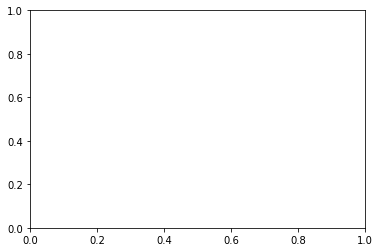

In [101]:
fig=plt.figure()
plt.plot(train_loss_summary)
plt.plot(cv_loss_summary)
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
fig.savefig('epochs_tuning.png',dpi=1000)

In [102]:
train_loss_summary

""
